# In this notebook, we take LEGO images downloaded from Kaggle, and use a pre-trained neural network to classify them

These LEGO figures are either from Harry Potter, Marvel, Jurrassic World, or Star Wars universe

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf 
import pandas as pd
import numpy as np
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

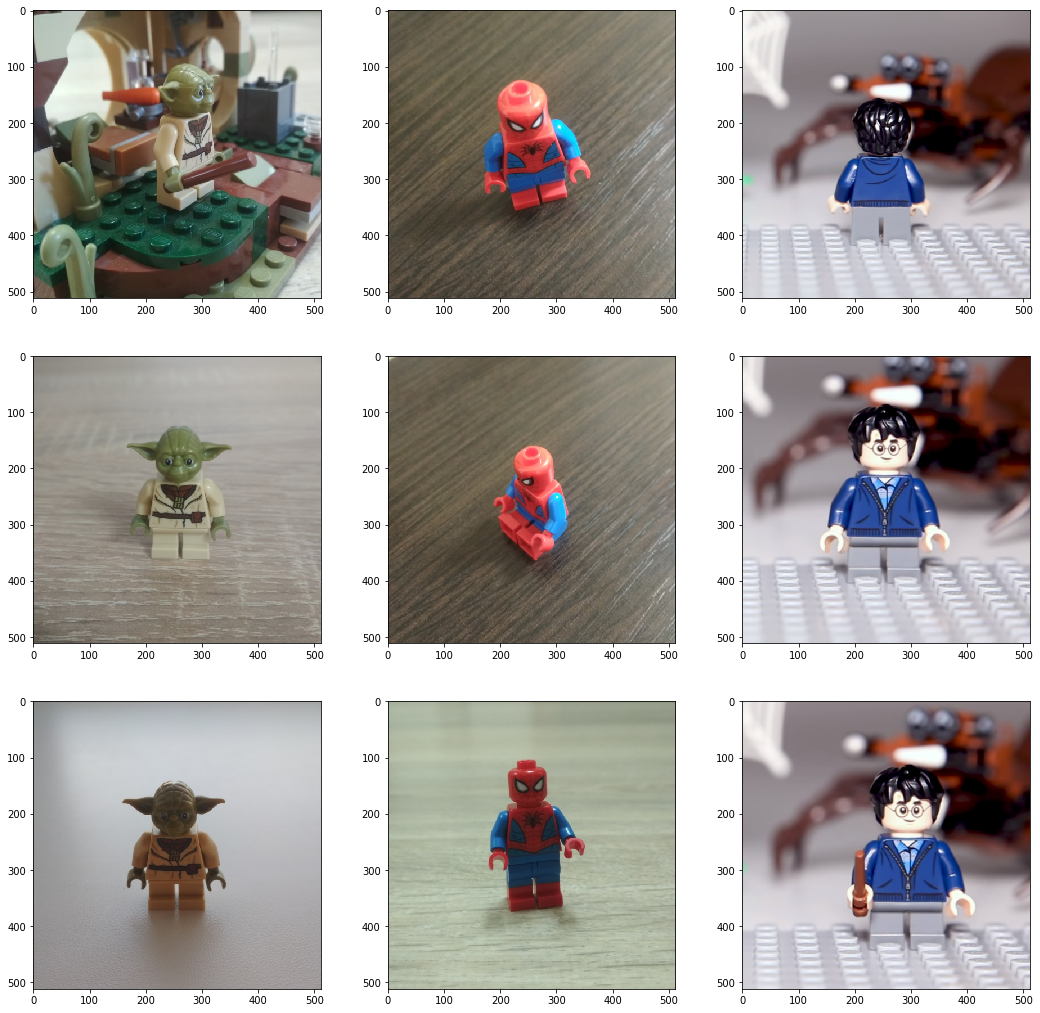

In [24]:
images = [[],[],[]]
index = ['001', '002', '003']

for i in range(3):
    images[i].append(mpimg.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/star-wars/0001/' + index[i] + '.jpg'))
    images[i].append(mpimg.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/marvel/0001/' + index[i] + '.jpg'))
    images[i].append(mpimg.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/harry-potter/0001/' + index[i] + '.jpg'))

fig, axs = plt.subplots(3,3, figsize=(18,18))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(images[i][j])

In [25]:
data = pd.read_csv('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/index.csv')
data

,Unnamed: 0,path,class_id,train-valid
0,0,marvel/0001/001.jpg,1,train
1,1,marvel/0001/002.jpg,1,valid
2,2,marvel/0001/003.jpg,1,train
3,3,marvel/0001/004.jpg,1,train
4,4,marvel/0001/005.jpg,1,train
...,...,...,...,...
299,299,jurassic-world/0002/010.jpg,27,train
300,300,jurassic-world/0002/011.jpg,27,valid
301,301,jurassic-world/0002/012.jpg,27,train
302,302,jurassic-world/0002/013.jpg,27,valid


In [26]:
#splitting into training and validation set
train_set = data[data["train-valid"] == 'train']
validation_set = data[data["train-valid"] == 'valid']

DenseNet (Densely Connected Convolutional Networks) was created by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger. This model has been trained on a very large amount of data and is able to distinguish many different objects.

As I already said, we will take a pre-trained DenseNet model, but change the last layer in it and also add our own output layer, so this model will classify what we need, in our case, Lego minifigures.

In [27]:
# take pretrained DenseNet
base_model = tf.keras.applications.DenseNet121()

# Create new Dropout layer and set its penultimate output from DenseNet 
my_layer = Dropout(0.5)(base_model.layers[-2].output)

# Count the nuber of unique classes in dataset
number_of_classes = len(data['class_id'].unique())

# Create new Dense layer and set the output from Dropout layer
# Note that in this Dense layer is "number_of_classes" neuron because we have "number_of_classes" classes 
my_outputs = Dense(number_of_classes, activation="softmax")(my_layer)
model = Model(base_model.input, my_outputs)


In [28]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(0.0001), metrics=['accuracy'])

The neural network accepts an image as input in the form of pixel values, so the code below simply transforms the images from the training and validation set into arrays of numbers and saves them.



In [29]:
X_train = np.zeros((train_set.shape[0], 224, 224, 3))

for i in range(train_set.shape[0]):
    image = cv2.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/' + train_set["path"].values[i])
    image = cv2.resize(image, dsize=(224,224)) # resize in case if image was not 224X224 pixels
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_train[i] = image/255

Y_train = np.array(train_set["class_id"])-1

X_valid = np.zeros((validation_set.shape[0], 224, 224, 3))

for i in range(validation_set.shape[0]):
    image = cv2.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/' + validation_set["path"].values[i])
    image = cv2.resize(image, dsize=(224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_valid[i] = image/255

Y_valid = np.array(validation_set["class_id"])-1
# Labels must be from 0 to n, but in our dataset labels from 1 to n, so above wen we save Y_valid and Y_train we subtract 1. 
#later on to get the correct answer, we will need to add 1 to the neural networks predictions

In [30]:
Y_train

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  7,  7,  8,  8,  4,  5,  6,  9,  9,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11,
       12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20,
       21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 26, 26,
       26, 26, 26, 26, 26])

In [31]:
'''
Before training the model, let's create the checkpoint for the model. It's mean that we will save only the best model. 
We do this because there may be a situation when, for example, 
we train the model for 50 epochs, but the best result was at 43 epochs, so if we do not save it, 
we will lose the best result and get only the final result from 50 epochs
'''
checkpoint = ModelCheckpoint(filepath='/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/mod.5', 
                             monitor="val_accuracy", save_best_only=True, verbose=1)

In [32]:
'''
Now let's train our model!
Note: the function fit() has a parameter "callbacks" where we will pass our checkpoint.
'''
model.fit(
    X_train, 
    Y_train, 
    epochs=50, 
    validation_data=(X_valid, Y_valid), 
    shuffle=True, 
    batch_size=4,
    callbacks=[checkpoint]
)

Train on 158 samples, validate on 146 samples
Epoch 1/50
156/158 [============================>.] - ETA: 0s - loss: 3.8992 - accuracy: 0.0449
Epoch 00001: val_accuracy improved from -inf to 0.10959, saving model to /Users/markroberts/Desktop/Effervescent_Ideas/LEGO/mod.5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/markroberts/Desktop/Effervescent_Ideas/LEGO/mod.5/assets
158/158 [==============================] - 134s 847ms/sample - loss: 3.9086 - accuracy: 0.0443 - val_loss: 3.2929 - val_accuracy: 0.1096
Epoch 2/50
156/158 [============================>.] - ETA: 0s - loss: 2.5080 - accuracy: 0.2885
Epoch 00002: val_accuracy improved from 0.10959 to 0.36986, saving model to /Users/markroberts/Desktop/Effervescent_Ideas/LEGO/mod.5
INFO:tensorflow:Assets written to: /Users/markroberts/Desktop/Effervescent_Ideas/LEGO/mod.5/assets
158/158 [==============================] - 104s 658ms/sample - loss: 2.5266 - accur

In [33]:
#loading saved 'best' model
model = load_model("/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/mod.5")


Class:	19	Minifigure:	RON WEASLEY


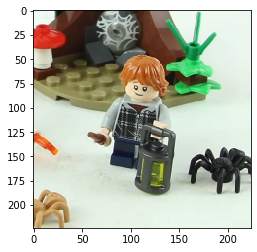

In [35]:
#showing off an example!
image = cv2.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/harry-potter/0002/009.jpg') # read the image 
image = cv2.resize(image, dsize=(224,224)) # resize in case if image was not 512x512 pixels
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255 # transform picture from BRG to the RGB format

plt.imshow(image) # print image 

image = np.reshape(image, (1, 224, 224, 3)) # resize to the needed for model shape - 1 picture 512 height 512 width 3 chanel(RGB)

ans = model.predict(image).argmax() # find index of max element
ans = ans+1 # don't forget to add 1!
metadata = pd.read_csv('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/metadata.csv') 
# download meta data, there are store real names of minifigures

minifigure = metadata["minifigure_name"][metadata["class_id"] == ans].iloc[0] # find the name that matches the predicted class
print(f"Class:\t{ans}\tMinifigure:\t{minifigure}")

Class:	5	Minifigure:	YODA


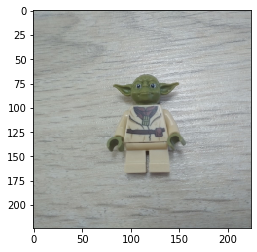

In [36]:
#showing off an example!
image = cv2.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/star-wars/0001/009.jpg') # read the image 
image = cv2.resize(image, dsize=(224,224)) # resize in case if image was not 512x512 pixels
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255 # transform picture from BRG to the RGB format

plt.imshow(image) # print image 

image = np.reshape(image, (1, 224, 224, 3)) # resize to the needed for model shape - 1 picture 512 height 512 width 3 chanel(RGB)

ans = model.predict(image).argmax() # find index of max element
ans = ans+1 # don't forget to add 1!
metadata = pd.read_csv('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/metadata.csv') 
# download meta data, there are store real names of minifigures

minifigure = metadata["minifigure_name"][metadata["class_id"] == ans].iloc[0] # find the name that matches the predicted class
print(f"Class:\t{ans}\tMinifigure:\t{minifigure}")

Class:	26	Minifigure:	OWEN GRADY


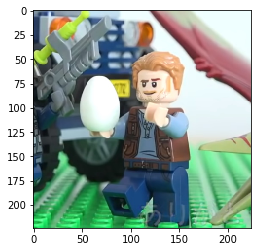

In [42]:
#showing off an example!
image = cv2.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/jurassic-world/0001/014.jpg') # read the image 
image = cv2.resize(image, dsize=(224,224)) # resize in case if image was not 512x512 pixels
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255 # transform picture from BRG to the RGB format

plt.imshow(image) # print image 

image = np.reshape(image, (1, 224, 224, 3)) # resize to the needed for model shape - 1 picture 512 height 512 width 3 chanel(RGB)

ans = model.predict(image).argmax() # find index of max element
ans = ans+1 # don't forget to add 1!
metadata = pd.read_csv('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/metadata.csv') 
# download meta data, there are store real names of minifigures

minifigure = metadata["minifigure_name"][metadata["class_id"] == ans].iloc[0] # find the name that matches the predicted class
print(f"Class:\t{ans}\tMinifigure:\t{minifigure}")

Class:	1	Minifigure:	SPIDER-MAN


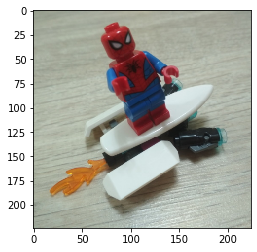

In [37]:
#showing off an example!
image = cv2.imread('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/marvel/0001/008.jpg') # read the image 
image = cv2.resize(image, dsize=(224,224)) # resize in case if image was not 512x512 pixels
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255 # transform picture from BRG to the RGB format

plt.imshow(image) # print image 

image = np.reshape(image, (1, 224, 224, 3)) # resize to the needed for model shape - 1 picture 512 height 512 width 3 chanel(RGB)

ans = model.predict(image).argmax() # find index of max element
ans = ans+1 # don't forget to add 1!
metadata = pd.read_csv('/Users/markroberts/Desktop/Effervescent_Ideas/LEGO/data/metadata.csv') 
# download meta data, there are store real names of minifigures

minifigure = metadata["minifigure_name"][metadata["class_id"] == ans].iloc[0] # find the name that matches the predicted class
print(f"Class:\t{ans}\tMinifigure:\t{minifigure}")

source: https://www.kaggle.com/izabellaleroy/guide-for-beginners-pretrained-neural-network/comments?select=model.h5